In [3]:
import sys
sys.path.append('/Users/andreas/fun/useful_py_func/pyTibber/tibber/')
#sys.path.append('/home/andram/fun/LED-env/lib/python3.11/site-packages/tibber')
from tibber import Tibber, gql_queries
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import parser
import asyncio
import serial
import json
import logging

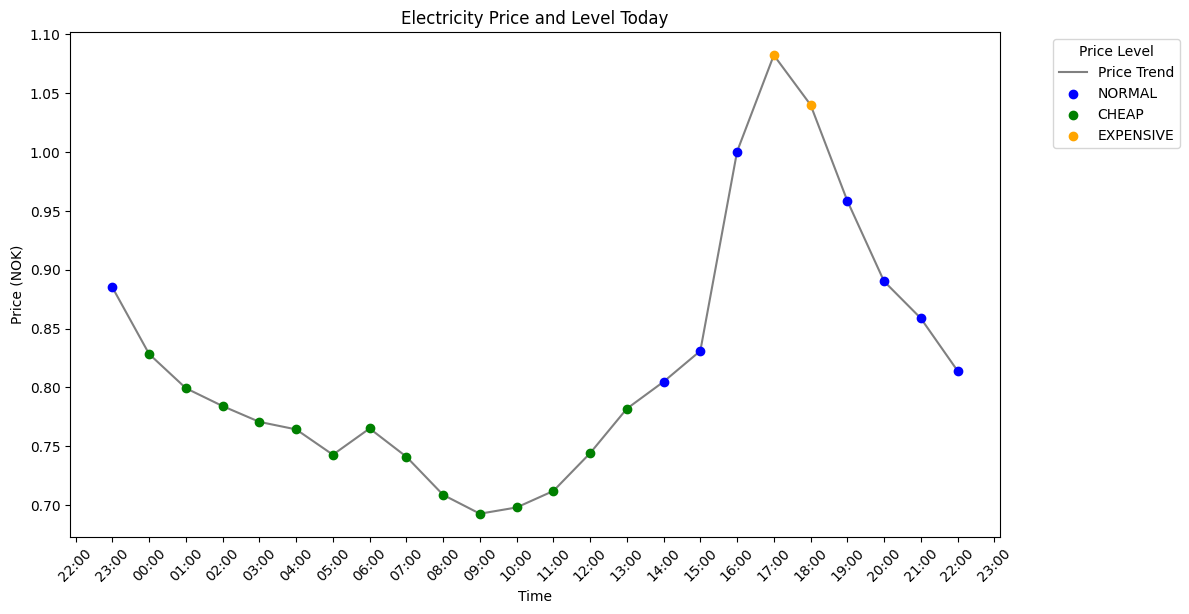

In [2]:
async def main():
    TOKEN = "U4L8yS_OHsfgKndAhNQZ8K-JYElbNUagYvToCF3ZPVE"
    USER_AGENT = "LED_client"
    HOME_ID = "975996b6-e7ca-4fbf-9f72-61e2df95bc0c"

    tibber_connection = Tibber(TOKEN, user_agent=USER_AGENT)
    await tibber_connection.update_info()
    
    # Fetch price information for today
    query = gql_queries.PRICE_INFO % HOME_ID
    data = await tibber_connection.execute(query)
    
    # Extract price information
    today_prices = data['viewer']['home']['currentSubscription']['priceInfo']['today']
    
    # Preparing data for plotting
    times = [parser.parse(price['startsAt']) for price in today_prices]
    prices = [price['total'] for price in today_prices]
    levels = [price['level'] for price in today_prices]

    await tibber_connection.close_connection()

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Mapping of levels to colors for plotting
    level_colors = {
        'NORMAL': 'blue',
        'CHEAP': 'green',
        'VERY_CHEAP': 'lightgreen',
        'EXPENSIVE': 'orange',
        'VERY_EXPENSIVE': 'red'
    }

    # Plot lines connecting the scatter points
    ax.plot(times, prices, color='grey', label='Price Trend', linestyle='-', marker='', zorder=1)

    # Plot each price point with a color indicating its level
    for time, price, level in zip(times, prices, levels):
        ax.scatter(time, price, color=level_colors[level], label=level if level not in ax.get_legend_handles_labels()[1] else "", zorder=2)

    ax.set_xlabel('Time')
    ax.set_ylabel('Price (NOK)')

    # Custom legend handling to ensure each level is represented once
    handles, labels = ax.get_legend_handles_labels()
    # Create a legend mapping each price level to its color, plus the price trend line
    legend_labels = {label: handle for handle, label in zip(handles, labels)}
    ax.legend(legend_labels.values(), legend_labels.keys(), title='Price Level', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Format the x-axis to show dates and times more clearly
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.title('Electricity Price and Level Today')
    plt.tight_layout()  # Adjust layout
    plt.xticks(rotation=45)
    plt.show()

await main()

In [1]:
class MicroBitCommunicator:
    def __init__(self, port='/dev/cu.usbmodem11102', baudrate=115200):
        self.port = port
        self.baudrate = baudrate
        self.serial_conn = None

    def connect(self):
        try:
            self.serial_conn = serial.Serial(self.port, self.baudrate)
            print("Connected to micro:bit on MacBook")
        except Exception as e:
            print(f"Failed to connect to micro:bit on {self.port}: {e}")

    def send_to_microbit(self, message, startsAt, total):
        full_message = f"{message},{startsAt},{round(total,2)}\n"
        try:
            self.serial_conn.write(full_message.encode('utf-8'))
            print(f"Sent to micro:bit: {full_message}")
        except Exception as e:
            print(f"Failed to send to micro:bit: {e}")

    def disconnect(self):
        if self.serial_conn:
            self.serial_conn.close()
            print("Disconnected from micro:bit")

class PriceCache:
    def __init__(self):
        self.cache = {'today': {}, 'tomorrow': {}}

    def update_cache(self, price_info):
        today_prices = price_info['viewer']['home']['currentSubscription']['priceInfo']['today']
        tomorrow_prices = price_info['viewer']['home']['currentSubscription']['priceInfo']['tomorrow']

        new_today_json = json.dumps(today_prices, sort_keys=True)
        new_tomorrow_json = json.dumps(tomorrow_prices, sort_keys=True)
        existing_today_json = json.dumps([self.cache['today'][hour] for hour in sorted(self.cache['today'])], sort_keys=True)
        existing_tomorrow_json = json.dumps([self.cache['tomorrow'][hour] for hour in sorted(self.cache['tomorrow'])], sort_keys=True)

        if new_today_json != existing_today_json:
            logging.info('Updating cache with new today prices.')
            for entry in today_prices:
                hour = parser.isoparse(entry['startsAt']).hour
                self.cache['today'][str(hour)] = entry

        if new_tomorrow_json != existing_tomorrow_json:
            logging.info('Updating cache with new tomorrow prices.')
            for entry in tomorrow_prices:
                hour = parser.isoparse(entry['startsAt']).hour
                self.cache['tomorrow'][str(hour)] = entry

    def get_current_price_info(self):
        now = datetime.now(timezone.utc).astimezone()
        current_hour = str(now.hour)

        day = 'today'
        if any(datetime.strptime(entry['startsAt'], '%Y-%m-%dT%H:%M:%S.%f%z').date() > now.date() for entry in self.cache['today'].values()):
            day = 'tomorrow'

        if current_hour in self.cache[day]:
            entry = self.cache[day][current_hour]
            return entry['level'], parser.isoparse(entry['startsAt']).strftime('%H:%M'), entry['total']
        return 'Unknown', '00:00', 0.0

async def hourly_update(tibber_connection, cache, home_id, microbit_communicator):
    while True:
        price_level, startsAt, total = cache.get_current_price_info()
        microbit_communicator.send_to_microbit(price_level, startsAt, total)

        now = datetime.now(timezone.utc).astimezone()
        next_hour = (now.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1))
        delay_seconds = max((next_hour - now).total_seconds(),5) #minimum delay of 5 seconds
        print(f"Waiting for next hourly price update in {delay_seconds} seconds.")
        await asyncio.sleep(delay_seconds)


async def fetch_prices_daily(tibber_connection, cache, home_id):
    while True:
        now = datetime.now(timezone.utc).astimezone()
        
        await fetch_prices(tibber_connection, cache, home_id)

        if '0' not in cache.cache['tomorrow']:
            first_attempt_time = now.replace(hour=18, minute=0, second=0, microsecond=0)
            if now < first_attempt_time:
                wait_seconds_until_first_attempt = (first_attempt_time - now).total_seconds()
                print(f"Waiting until 18:00 for the first attempt to fetch tomorrow's data in {wait_seconds_until_first_attempt} seconds.")
                await asyncio.sleep(wait_seconds_until_first_attempt)
            
            while '0' not in cache.cache['tomorrow']:
                await fetch_prices(tibber_connection, cache, home_id)
                await asyncio.sleep(3600)

        next_fetch_time = (datetime.now(timezone.utc).astimezone() + timedelta(days=1)).replace(hour=14, minute=0, second=0, microsecond=0)
        wait_seconds = (next_fetch_time - datetime.now(timezone.utc).astimezone()).total_seconds()
        print(f"Waiting for next daily price update in {wait_seconds} seconds.")
        await asyncio.sleep(wait_seconds)



async def fetch_prices(tibber_connection, cache, home_id):
    query = gql_queries.PRICE_INFO % home_id
    data = await tibber_connection.execute(query)
    if data:
        cache.update_cache(data)
        print("Cache updated with new price information.")
    else:
        print("No data returned from the API.")

async def daily_updates(tibber_connection, cache, home_id, microbit_communicator):
    asyncio.create_task(fetch_prices_daily(tibber_connection, cache, home_id))
    await fetch_prices(tibber_connection, cache, home_id)
    await hourly_update(tibber_connection, cache, home_id, microbit_communicator)


async def main():
    TOKEN = "U4L8yS_OHsfgKndAhNQZ8K-JYElbNUagYvToCF3ZPVE"
    USER_AGENT = "LED_client"
    HOME_ID = "975996b6-e7ca-4fbf-9f72-61e2df95bc0c"

    tibber_connection = Tibber(access_token=TOKEN, user_agent=USER_AGENT)
    await tibber_connection.update_info()
    
    cache = PriceCache()
    microbit_communicator = MicroBitCommunicator()
    microbit_communicator.connect()

    await daily_updates(tibber_connection, cache, HOME_ID, microbit_communicator)

    await tibber_connection.close_connection()
    microbit_communicator.disconnect()

await main()

Connected to micro:bit on MacBook
Cache updated with new price information.
Sent to micro:bit: CHEAP,11:00,0.85

Waiting for next hourly price update in 2020.360946 seconds.
Cache updated with new price information.
Waiting until 18:00 for the first attempt to fetch tomorrow's data in 23620.427854 seconds.


In [ ]:
"https://microbit-micropython.readthedocs.io/en/v1.0.1/microbit_micropython_api.html"